In [3]:
# Facebook Prophet
# 超参数
VAULE_X = 'date'
VAULE_Y = 'amount'

import pandas as pd
from pandas import to_datetime
import numpy as np
from matplotlib import pyplot

from prophet import Prophet

(364, 12)
       date  order_cnt       amount text_day text_night  high  low wc_day  \
0  2023-1-1     902538  268544969.5        阴          阴     8    5    <3级   
1  2023-1-2    1066437  323796828.3        阴         多云     9    0    <3级   
2  2023-1-3    1216502  386938985.1       多云         多云     9    0    <3级   
3  2023-1-4     874633  271284119.0       多云         多云    12    3   3~4级   
4  2023-1-5     901227  283022796.0       多云         多云    13    2    <3级   

  wd_day wc_night wd_night week  
0     东风      <3级      东北风  星期日  
1     北风      <3级       东风  星期一  
2    东南风      <3级       东风  星期二  
3    东南风      <3级       东风  星期三  
4     南风      <3级       西风  星期四  


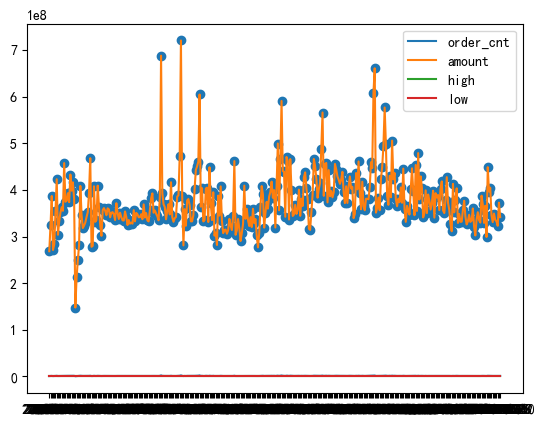

In [4]:

# 读取excel文件并获取指定列
#df = pd.read_csv('Data\结果1_全站按日数据_最近2年数据.csv', usecols=['date', 'amount', 'order_cnt', 'text_day', 'text_night', 'high', 'low', 'wc_day', 'wd_day', 'wc_night', 'wd_night', 'week', 'holidays'], encoding='GBK')
df = pd.read_csv('Data\结果1_全站按日期分组_2023全年.csv', usecols=['date', 'amount', 'order_cnt', 'text_day', 'text_night', 'high', 'low', 'wc_day', 'wd_day', 'wc_night', 'wd_night', 'week'], encoding='GBK')

print(df.shape)
print(df.head())
df.plot()

# 设置字体，确保能正确显示汉字
pyplot.rcParams['font.sans-serif'] = ['SimHei']  # 设置中文字体

# 绘制散点图
pyplot.scatter(df[VAULE_X], df[VAULE_Y])
pyplot.show()

10:01:23 - cmdstanpy - INFO - Chain [1] start processing
10:01:23 - cmdstanpy - INFO - Chain [1] done processing


          ds          yhat    yhat_lower    yhat_upper
0 2023-12-01  3.836199e+08  3.186530e+08  4.502026e+08
1 2023-12-02  3.652327e+08  2.973412e+08  4.295717e+08
2 2023-12-03  3.442965e+08  2.760672e+08  4.086976e+08
3 2023-12-04  3.629580e+08  2.987897e+08  4.284332e+08
4 2023-12-05  3.614969e+08  2.945014e+08  4.289656e+08


d:\Python312\Lib\site-packages\prophet\plot.py:72: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  fcst_t = fcst['ds'].dt.to_pydatetime()
d:\Python312\Lib\site-packages\prophet\plot.py:73: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  ax.plot(m.history['ds'].dt.to_pydatetime(), m.history['y'], 'k.',


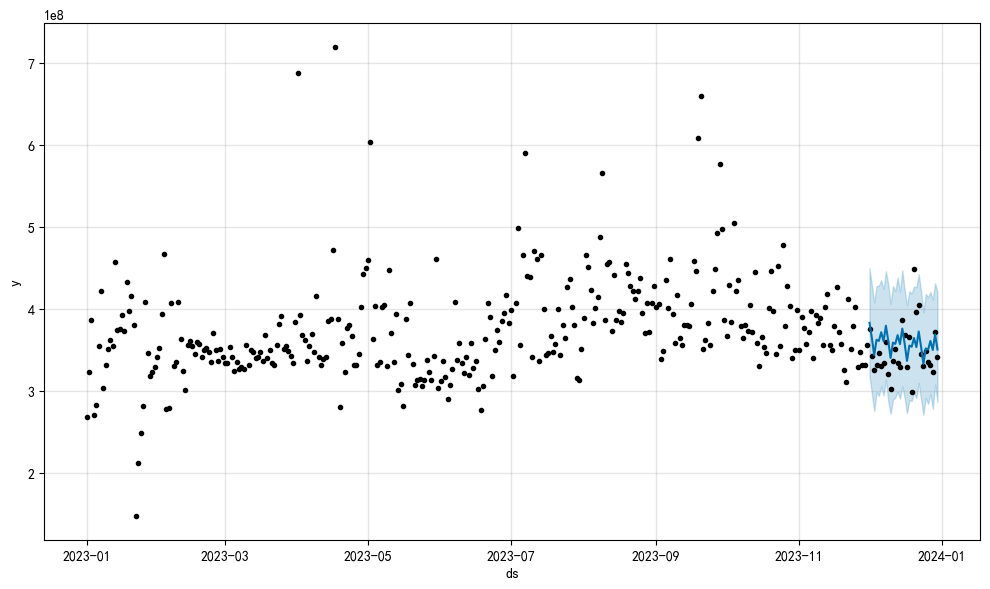

In [6]:

# 第一步：构建输入DataFrame 
# 第一列必须被命名为“ds”并包含日期信息； 第二列必须被命名为“y”并包含观测结果。
df_prophet = df[['date', 'amount']].copy()
df_prophet.rename(columns={'date':'ds', 'amount':'y'}, inplace=True) 

# 第二步：模型拟合
model = Prophet()
model.add_country_holidays(country_name="CN")
model.fit(df_prophet)

# 第三步：构建预测DataFrame：future, 这个future是预测的日期，只有2023-06-01至30日的数据
future = list()
for i in range(1, 31):
    dateToPredict = '2023-12-%02d' % i
    future.append([dateToPredict])
future = pd.DataFrame(future)
future.columns = ['ds']
future['ds']= to_datetime(future['ds'])

# 第四步：模型预测
forecast = model.predict(future)
print(forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].head())

# 第五步：绘制图形
model.plot(forecast)
pyplot.show()

10:01:45 - cmdstanpy - INFO - Chain [1] start processing
10:01:45 - cmdstanpy - INFO - Chain [1] done processing


          ds          yhat    yhat_lower    yhat_upper
0 2023-12-01  3.982627e+08  3.318988e+08  4.680926e+08
1 2023-12-02  3.820614e+08  3.137864e+08  4.501410e+08
2 2023-12-03  3.613958e+08  3.002682e+08  4.337807e+08
3 2023-12-04  3.798601e+08  3.091075e+08  4.426454e+08
4 2023-12-05  3.795385e+08  3.119292e+08  4.468984e+08


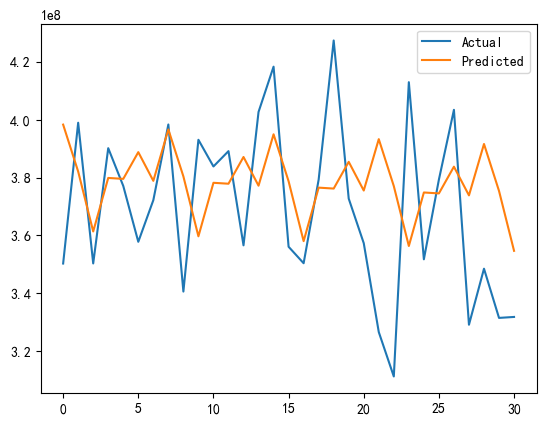

In [7]:
# 第六步：评估效果
## 第6.1步：留出检验集（扔掉后31行）
df_prophet_train = df_prophet.drop(df_prophet.index[-31:])

## 第6.2步：模型拟合（用中国的节假日）
model = Prophet()
model.add_country_holidays(country_name="CN")
model.fit(df_prophet_train)

## 第6.3步：构建预测集
df_prophet_future = list()
for i in range(1, 32):
    dateToPredict = '2023-12-%02d' % i
    df_prophet_future.append([dateToPredict])
df_prophet_future = pd.DataFrame(df_prophet_future)
df_prophet_future.columns = ['ds']
df_prophet_future['ds']= to_datetime(df_prophet_future['ds'])

## 第6.4步：模型预测
forecast = model.predict(df_prophet_future)
print(forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].head())

## 第6.5步：比较检验集和预测集两者差异
y_true = df_prophet_train['y'][-31:].values
y_pred = forecast['yhat'].values
pyplot.plot(y_true, label='Actual')
pyplot.plot(y_pred, label='Predicted')
pyplot.legend()
pyplot.show()